# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [1]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 


## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


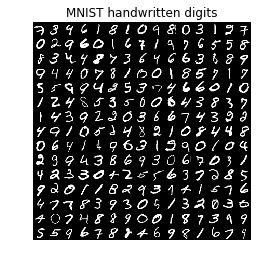

In [2]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)



## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [12]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


In [13]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 2
kernel_size_1 = (4,4)
pool_size_1 = (3,3)
#EX1-2
#filters_2 = 256
#kernel_size_2 = (6, 6)
#pool_size_2 = (5, 5)
#EX1-2

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())

#EX1-2
#with tf.variable_scope('convLayer2'):
#    conv2 = Conv2D(filters_2, kernel_size_2, strides=(3, 3), padding=padding, activation='relu')
#    x = conv2(x)
#    print('conv2 \t\t', x.get_shape())
#    pool2 =AveragePooling2D(pool_size=pool_size_2, strides=None, padding=padding)
#    x = pool2(x)
#    print('pool2 \t\t', x.get_shape())
#    x = flatten(x)
#    print('Flatten \t', x.get_shape())
#EX1-2

with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 2)
pool1 		 (?, 10, 10, 2)
Flatten 	 (?, 200)
denseOut	 (?, 10)
Model consits of  2044 trainable parameters.


In [5]:
## Launch TensorBoard, and visualize the TF graph
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [6]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


## Training

In [8]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass


Begin training loop
Epoch 1 : Train Loss  0.421, Train acc  0.870,  Valid loss  0.388,  Valid acc  0.887
Epoch 2 : Train Loss  0.204, Train acc  0.930,  Valid loss  0.301,  Valid acc  0.909
Epoch 3 : Train Loss  0.170, Train acc  0.980,  Valid loss  0.266,  Valid acc  0.923
Epoch 4 : Train Loss  0.183, Train acc  0.950,  Valid loss  0.244,  Valid acc  0.928
Epoch 5 : Train Loss  0.307, Train acc  0.890,  Valid loss  0.233,  Valid acc  0.933
Epoch 6 : Train Loss  0.339, Train acc  0.900,  Valid loss  0.220,  Valid acc  0.935
Epoch 7 : Train Loss  0.278, Train acc  0.910,  Valid loss  0.210,  Valid acc  0.939
Epoch 8 : Train Loss  0.086, Train acc  0.970,  Valid loss  0.205,  Valid acc  0.936
Epoch 9 : Train Loss  0.112, Train acc  0.970,  Valid loss  0.198,  Valid acc  0.938
Epoch 10 : Train Loss  0.125, Train acc  0.950,  Valid loss  0.189,  Valid acc  0.941
Test Loss  0.186, Test acc  0.946


(<matplotlib.text.Text at 0x7ff079c6e0b8>,
 (0.75, 1.03))

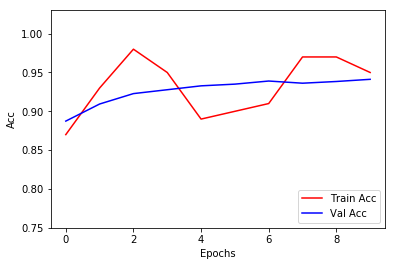

In [9]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# First launch (No modif)
Begin training loop
* Epoch 1 : Train Loss  0.137, Train acc  0.950,  Valid loss  0.128,  Valid acc  0.965
* Epoch 2 : Train Loss  0.162, Train acc  0.940,  Valid loss  0.089,  Valid acc  0.974
* Epoch 3 : Train Loss  0.143, Train acc  0.970,  Valid loss  0.076,  Valid acc  0.977
* Epoch 4 : Train Loss  0.066, Train acc  0.980,  Valid loss  0.069,  Valid acc  0.979
* Epoch 5 : Train Loss  0.123, Train acc  0.970,  Valid loss  0.062,  Valid acc  0.981
* Epoch 6 : Train Loss  0.052, Train acc  0.960,  Valid loss  0.057,  Valid acc  0.984
* Epoch 7 : Train Loss  0.022, Train acc  1.000,  Valid loss  0.058,  Valid acc  0.983
* Epoch 8 : Train Loss  0.027, Train acc  0.990,  Valid loss  0.055,  Valid acc  0.983
* Epoch 9 : Train Loss  0.093, Train acc  0.960,  Valid loss  0.052,  Valid acc  0.985
* Epoch 10 : Train Loss  0.029, Train acc  0.990,  Valid loss  0.055,  Valid acc  0.984
* Test Loss  0.048, Test acc  0.985

# With resolution reduced
Begin training loop
* Epoch 1 : Train Loss  0.435, Train acc  0.910,  Valid loss  0.343,  Valid acc  0.902
* Epoch 2 : Train Loss  0.240, Train acc  0.910,  Valid loss  0.260,  Valid acc  0.929
* Epoch 3 : Train Loss  0.281, Train acc  0.900,  Valid loss  0.220,  Valid acc  0.937
* Epoch 4 : Train Loss  0.350, Train acc  0.910,  Valid loss  0.199,  Valid acc  0.942
* Epoch 5 : Train Loss  0.192, Train acc  0.950,  Valid loss  0.186,  Valid acc  0.946
* Epoch 6 : Train Loss  0.086, Train acc  0.970,  Valid loss  0.175,  Valid acc  0.949
* Epoch 7 : Train Loss  0.233, Train acc  0.930,  Valid loss  0.173,  Valid acc  0.948
* Epoch 8 : Train Loss  0.169, Train acc  0.930,  Valid loss  0.160,  Valid acc  0.951
* Epoch 9 : Train Loss  0.097, Train acc  0.970,  Valid loss  0.155,  Valid acc  0.953
* Epoch 10 : Train Loss  0.161, Train acc  0.950,  Valid loss  0.152,  Valid acc  0.953
* Test Loss  0.137, Test acc  0.957


# Assignments

#### <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features.

___

<span style="color:blue"> Answer: </span>


1. Convolution :

    | 8 | 20|
    
    |14 | 25|


2. Pooling : 25



#### <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

<span style="color:blue"> Write down what you did: </span>
``` 
with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    # No flattening needed at this level because we have another layer
    #x = flatten(x)
    #print('Flatten \t', x.get_shape())


with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(3, 3), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())
    pool2 =AveragePooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())
    ``` 

Trace :

``` 
Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
conv2 		 (?, 5, 5, 256)
pool2 		 (?, 1, 1, 256)
Flatten 	 (?, 256)
denseOut	 (?, 10)
Model consits of  150698 trainable parameters.
``` 

#### <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___


<span style="color:blue"> Answer: </span>

With this reduced set of parameters :
* 1 layer
* 2 filters
* Kernel size = (4, 4)
* Pooling size = (3, 3)
We get an accuracy of 0.952 on the validation set and 0.957 on the test set, with only 2044 parameters

We gain more performance out of low number of parameters if we keep the kernel size high and a low number of filters. Pooling reduces drastically the number of parameters, it is consistent with the definition of polling operations.


#### <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___

<span style="color:blue"> Describe your findings: </span>

Reusing the densely feed forward network from lab 1, we can first see that even the one created (made of two layers of respectively 100 and 10 neurons) doesn't reach this level of performance and performs at 0.844 on validation and 0.918 on the test set. This network uses 79510 trainable parameters.

By reducing the densely neural network at its lowest number of trainable parameters (1 layer with num_features inputs and num_classes neurons and outputs) which is 7850 we reach a lower performance level with 0.781 on validation and 0.848 on test.

# Exercise from Michael Nielsen book
##### Sigmoid neurons simulating perceptrons, part II

Suppose we have the same setup as the last problem - a network of perceptrons. Suppose also that the overall input to the network of perceptrons has been chosen. We won't need the actual input value, we just need the input to have been fixed. Suppose the weights and biases are such that w⋅x+b≠0 for the input x to any particular perceptron in the network. Now replace all the perceptrons in the network by sigmoid neurons, and multiply the weights and biases by a positive constant c>0. Show that in the limit as c→∞ the behaviour of this network of sigmoid neurons is exactly the same as the network of perceptrons. How can this fail when w⋅x+b=0 for one of the perceptrons?


We have a network with sigmoid neurons, so the activation function of each neuron is the sigmoid function :
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

We multiply weights and biases by $c > 0$, the output of sigmoids is thus :
$$
y_{out} = \sigma(\sum_j{w_jcx + bc}) = \frac{1}{1 + e^{\sum_j{-w_jcx - bc}}}
y_{out} = \frac{1}{1 + e^{-c(w \cdot x + b)}}
$$

When $c \to \infty$ we have three output possibilities regarding the sign of $\{w \cdot x + b$ :

$$
y_{out_{c \to \infty}} =
\begin{cases}
    \frac{1}{1 + e^{+\infty}} = 0 & \quad \text{if  } w \cdot x + b < 0 \\
    \frac{1}{1 + e^{-\infty}} = 1 & \quad \text{if  } w \cdot x + b  > 0 \\
    \frac{1}{1 + e^{0}} = \frac{1}{2} & \quad \text{if  } w \cdot x + b  = 0
\end{cases}
$$

This is the same output obtained with the perceptrons if we consider that weights and biases are such that $w\cdot x+b≠0$ for the input x :

$$
y_{perc} = 
\begin{cases}
    0 & \text{if  } w \cdot x + b \leq 0\\
    1 & \text{if  } w \cdot x + b > 0
\end{cases}
$$


We can see that, if one of the perceptrons has $w\cdot x+b = 0$ then the sigmoid equivalent would have $\frac{1}{2}$ as output. The perceptron can't reach this state (only O or 1) and would output 0 which is different from the sigmoid version.

